

Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/04/05


In [36]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import scipy
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sb.set_style('darkgrid')

# Validating linear regression
## Predicting Property Crime from Population, Murder and Robbery statistics. 

The 2014 table 8 FBI data for New York will be used to validate the 2013 crime data.  Some city names with in the 2014 file have numbers appended to the name that need to be removed. In addition, many of the same removing of outliers and data transformation steps that were needed for the 2013 dataset must also carried out on the 2014 dataset.

The 2014 dataset has already been cleaned, transformed and persisted to CSV. 
Our original model use the following formula to predict property crime. 

$$Property Crime = \alpha + \beta_1Population+ \beta_2Robbery + \beta_3Burglary + \beta_4Murder$$

After performing the transformation steps needed to appease the requirements of Linear Regression our formula for the model is the following. Where the features Robbery and Murder are categorical data.


$$\sqrt{Property Crime} = \alpha + \beta_1\log_Population+ \beta_2Robbery + \beta_3\sqrt{Burglary} + \beta_4Murder$$


In [2]:
# Set of useful functions for investigating the column data and removing extraneous number characters from strings. 
import re

def has_numeric(string):
    has_numeric = False
    result = re.search(r'\d', string)
    if result is not None:
        has_numeric = True
    return has_numeric, result


def remove_numeric(label):
    has_numbers, match = has_numeric(label)
    result = label
    if has_numbers:
        positions = match.span()
        first = label[0:positions[0]]
        second = label[positions[1] + 1 :]
        result = first + second
    return result
        
        
def retrieve_metadata(dataframe):
    """
     Extracts the shape, column names and number of null rows for
     each column of a Pandas data frame. This information is printed
     to standard ouput.

     Args:
        dataframe (dataframe): The Pandas data frame of interest

     Returns:
        Nothing
    """
    num_rows, num_columns = dataframe.shape
    columns = dataframe.columns.values.tolist()
    print('Data frame contains %d columns and %d rows' % (num_columns, num_rows))
    for elem in columns:
        print('\ncolumn %s has %d empty rows'% (elem, sum(dataframe[elem].isnull())))
        print('column %s statistics\n%s\n'% (elem, dataframe[elem].describe()))
    

def convert_to_float(item):
    if isinstance(item, str):
        return float(item)

Reading in the new data set with which we will validate our 2013 crime data with. The city names are cleaned of any trailing numbers and simple statistics for each columns are displayed.  The pair plot of column data in scatter and histograms are displayed to better visualize outliers.

In [3]:
data_2_path = '/media/ianh/space/ThinkfulData/NYCrimeData/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.csv'
data_2 = pd.read_csv(data_2_path, usecols=['Property crime', 'City','Population', 'Robbery', 'Burglary', 'Murder'])
# removing trailing number characters from city names
data_2['City'] = data_2.City.apply(remove_numeric)

# All other read in columns are of type str and are converted to float for analysis 
data_2['Property crime'] = data_2['Property crime'].str.replace(',','').astype(np.float64)
data_2.Population = data_2.Population.str.replace(',','').astype(int)
data_2.Robbery = data_2.Robbery.str.replace(',','').astype(int)
data_2.Burglary = data_2.Burglary.str.replace(',','').astype(int)
data_2.Murder = data_2.Murder.astype(int)
retrieve_metadata(data_2)
#_ = sb.pairplot(data_2.dropna())

Data frame contains 6 columns and 369 rows

column City has 0 empty rows
column City statistics
count         369
unique        369
top       Corning
freq            1
Name: City, dtype: object


column Population has 0 empty rows
column Population statistics
count    3.690000e+02
mean     3.781482e+04
std      4.411591e+05
min      7.900000e+01
25%      2.631000e+03
50%      6.581000e+03
75%      1.540800e+04
max      8.473938e+06
Name: Population, dtype: float64


column Murder has 0 empty rows
column Murder statistics
count    369.000000
mean       1.452575
std       17.693912
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      333.000000
Name: Murder, dtype: float64


column Robbery has 0 empty rows
column Robbery statistics
count      369.000000
mean        60.661247
std        866.480865
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max      16581.000000
Name: Robbery, dtype: float64


column Property 

Similar to the 2013 dataset the 5 largest cities in New York State, New York City, Buffalo, Rochester, Syracuse and Yonkers are our skewing the distributions of all features. Will remove these data points and plot the results. 

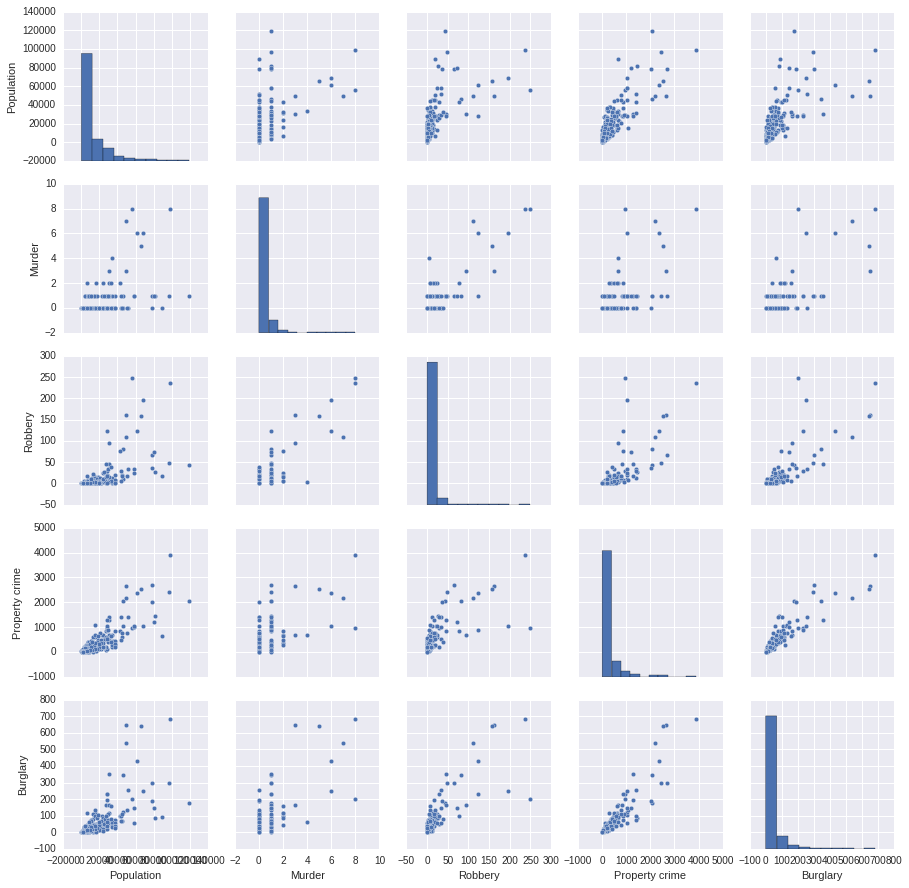

In [4]:
data_2 = data_2[data_2.City != "New York"]
data_2 = data_2[data_2.City != "Rochester"]
data_2 = data_2[data_2.City != "Buffalo"]
data_2 = data_2[data_2.City != "Syracuse"]
data_2 = data_2[data_2.City != "Yonkers"]
_ = sb.pairplot(data_2.dropna())

There are many data points that have either 0 or 1 for the number of Murders and Robberies in 2014. This two Features will be will be converted to categorical features.

In [5]:
retrieve_metadata(data_2)

Data frame contains 6 columns and 364 rows

column City has 0 empty rows
column City statistics
count         364
unique        364
top       Corning
freq            1
Name: City, dtype: object


column Population has 0 empty rows
column Population statistics
count       364.000000
mean      12818.153846
std       17304.640910
min          79.000000
25%        2614.500000
50%        6444.000000
75%       15204.000000
max      118860.000000
Name: Population, dtype: float64


column Murder has 0 empty rows
column Murder statistics
count    364.000000
mean       0.255495
std        0.966718
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: Murder, dtype: float64


column Robbery has 0 empty rows
column Robbery statistics
count    364.000000
mean       8.417582
std       27.869260
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max      248.000000
Name: Robbery, dtype: float64


column Property crime ha

In [6]:
data_2["Murder_Cat"] = np.where(data_2.Murder == 0, 0, 1)
data_2["Robbery_Cat"] = np.where(data_2.Robbery == 0, 0, 1)
data_2.head()

,City,Population,Murder,Robbery,Property crime,Burglary,Murder_Cat,Robbery_Cat
0,Adams Village,1851,0,0,11.0,1,0,0
1,Addison Town and Village,2568,0,1,49.0,1,0,1
2,Afton Village,820,0,0,1.0,0,0,0
3,Akron Village,2842,0,0,17.0,0,0,0
4,Albany,98595,8,237,3888.0,683,1,1


None of the Features have a distribution close to a normal distribution. Time to starting transforming the features to see how close we can theor distributions to normal.

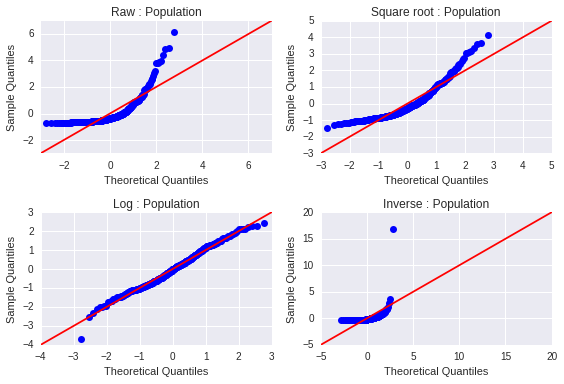

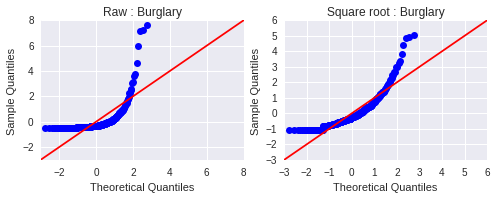

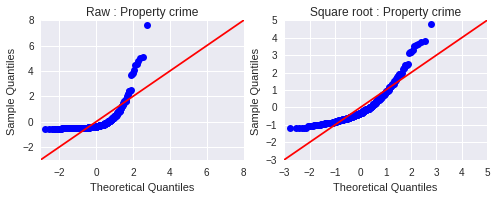

In [7]:
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data_2.Population, line='45', fit=True, ax=ax)
ax.set_title('Raw : Population')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data_2.Population), line='45', fit=True, ax=ax)
ax.set_title('Square root : Population')

ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(np.log(data_2.Population), line='45', fit=True, ax=ax)
ax.set_title('Log : Population')

ax = fig.add_subplot(2, 2, 4)
sm.graphics.qqplot(1/data_2.Population, line='45', fit=True, ax=ax)
ax.set_title('Inverse : Population')
plt.tight_layout()

# Burglary
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data_2.Burglary, line='45', fit=True, ax=ax)
ax.set_title('Raw : Burglary')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data_2.Burglary), line='45', fit=True, ax=ax)
ax.set_title('Square root : Burglary')

# Property crime
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data_2['Property crime'].dropna(), line='45', fit=True, ax=ax)
ax.set_title('Raw : Property crime')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data_2['Property crime'].dropna()), line='45', fit=True, ax=ax)
ax.set_title('Square root : Property crime')


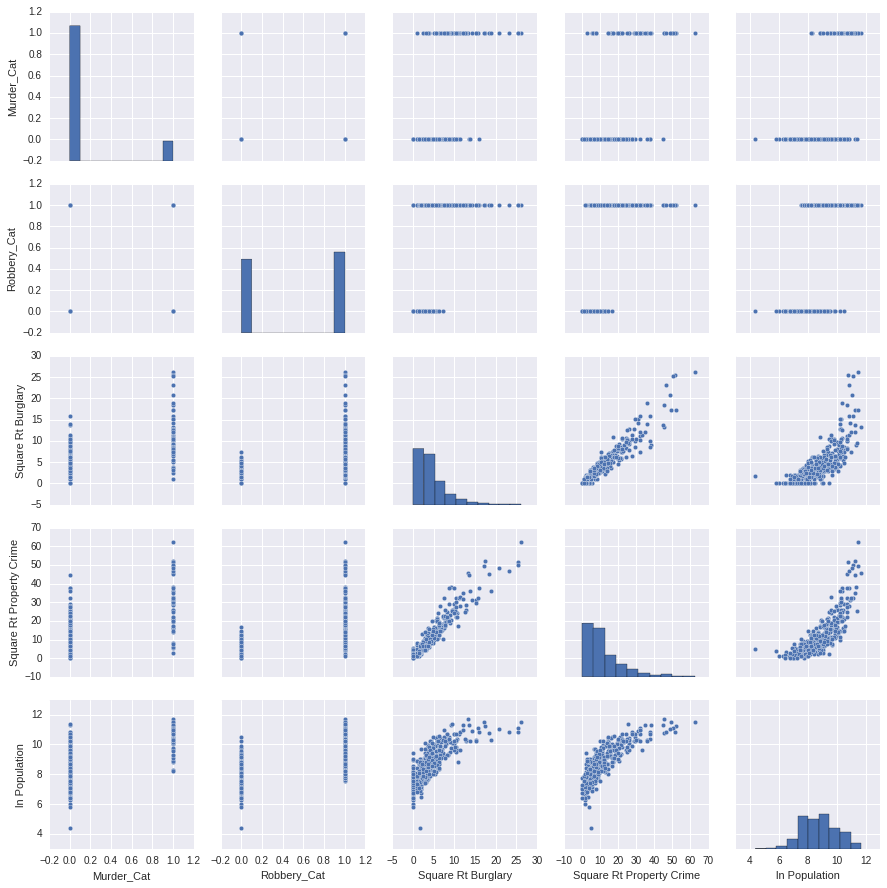

In [13]:
# Adding the log of the raw Population data points into data frame.
data_2['ln Population'] = np.log(data_2.Population)

# Taking the square root of the Property crime data points.
data_2['Square Rt Property Crime'] = np.sqrt(data_2['Property crime'])

# Taking the square root of the Burglary data points.
data_2['Square Rt Burglary'] = np.sqrt(data_2.Burglary)

# filtering out those columns no longer needed
exclude = ['Population', 'Murder', 'Robbery', 'Property crime', 'Burglary']
_ = sb.pairplot(data_2.ix[:, data_2.columns.difference(exclude)].dropna())

The same cleaning and transformations steps were carried out on the 2014 data set as was carried out on the 2013 table 8 dataset. The resulting data is persisted to the file system. The 2013 dataset is read from the file system and merged with the 2014 dataset to provide a larger set of training for the model.

In [34]:
transformed_2 = data_2.ix[:, data_2.columns.difference(exclude)]
file_path = '/media/ianh/space/ThinkfulData/NYCrimeData/clean_transformed_NY2014_data.csv'
transformed_2.to_csv(file_path)

file_path_2013 = '/media/ianh/space/ThinkfulData/NYCrimeData/clean_transformed_NY2013_data.csv'
transformed = pd.read_csv(file_path_2013)

# Remove city name column to prevent any data amalgamation on city name during concatenation 
del transformed_2['City']
del transformed['City']

# Now concatenate the two data frames
both_datasets = pd.concat([transformed_2, transformed], ignore_index=True)
both_dataset  = both_datasets.dropna()
both_datasets.head()

,Murder_Cat,Robbery_Cat,Square Rt Burglary,Square Rt Property Crime,ln Population
0,0,0,1.000000,3.316625,7.523481
1,0,1,1.000000,7.000000,7.850883
2,0,0,0.000000,1.000000,6.709304
3,0,0,0.000000,4.123106,7.952263
4,1,1,26.134269,62.353829,11.498776


In [35]:
from sklearn.cross_validation import train_test_split

# setting our overall data X, and y
X = both_datasets[['ln Population','Robbery_Cat','Square Rt Burglary', 'Murder_Cat']]
y = both_datasets['Square Rt Property Crime']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y) 
# X_train and y_train will be used to train the model
# X_test and y_test will be used to test the model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, y_train))


Coefficients: 
 [ 1.7444297   1.13867763  1.82288688  0.10118439]

Intercept: 
 -12.3503705743

R-squared:
0.916987855553


### Multivariate normality

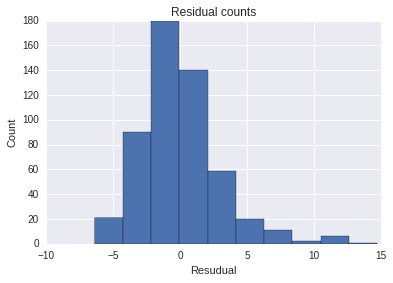

In [37]:
# Extract predicted values.
predicted = regr.predict(X_train).ravel()
actual = y_train

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()


### Homoscedasticity

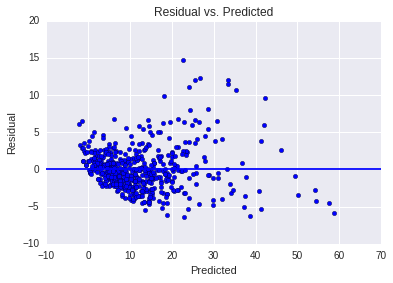

In [38]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Multicollinearity

In [39]:
correlation_matrix = X_train.corr()
display(correlation_matrix)

,ln Population,Robbery_Cat,Square Rt Burglary,Murder_Cat
ln Population,1.000000,0.645310,0.759788,0.434996
Robbery_Cat,0.645310,1.000000,0.563952,0.290603
Square Rt Burglary,0.759788,0.563952,1.000000,0.558708
Murder_Cat,0.434996,0.290603,0.558708,1.000000


### Individual parameters